In [1]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

Extracting data/MNIST\raw\train-images-idx3-ubyte.gz to data/MNIST\raw


Extracting data/MNIST\raw\train-labels-idx1-ubyte.gz to data/MNIST\raw



Extracting data/MNIST\raw\t10k-images-idx3-ubyte.gz to data/MNIST\raw


Extracting data/MNIST\raw\t10k-labels-idx1-ubyte.gz to data/MNIST\raw
Processing...


C:\Users\shobhit\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


image.shape: torch.Size([1, 28, 28])
label: 5


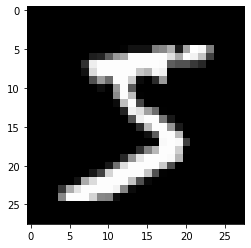

In [14]:
image, label = dataset[0]
print('image.shape:', image.shape)
plt.imshow(image[0], cmap='gray')
print('label:', label)

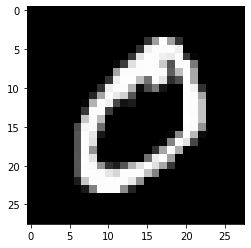

In [40]:
image, _ = dataset[1]
image.shape
plt.imshow(image[0], cmap = 'gray')

In [16]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [17]:
bs = 128

In [18]:
train_loader = DataLoader(train_ds, bs, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, bs*2, num_workers=4, pin_memory=True)

images.shape: torch.Size([128, 1, 28, 28])


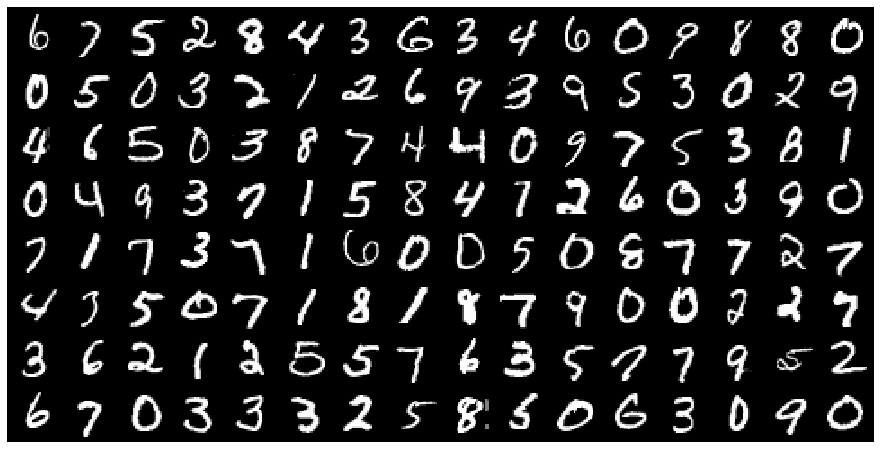

In [25]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break          

In [41]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    inputs = images.reshape(-1, 784)
    print('inputs.shape:', inputs.shape)
    break


images.shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


In [46]:
input_size = inputs.shape[-1]
hidden_size1 = 64

In [47]:
layer1 = nn.Linear(input_size, hidden_size1)

In [48]:
inputs.shape

torch.Size([128, 784])

In [49]:
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape:', layer1_outputs.shape)

layer1_outputs.shape: torch.Size([128, 64])


In [52]:
relu_outputs1 = F.relu(layer1_outputs)
print('min(layer1_outputs):', torch.min(layer1_outputs).item())
print('min(relu_outputs1):', torch.min(relu_outputs1).item())

min(layer1_outputs): -0.8263249397277832
min(relu_outputs1): 0.0


In [53]:
hidden_size2 = 32
layer2 = nn.Linear(hidden_size1, hidden_size2)

In [54]:
layer2_outputs = layer2(relu_outputs1)
print(layer2_outputs.shape)

torch.Size([128, 32])


In [55]:
relu_outputs2 = F.relu(layer2_outputs)
print('min(layer2_outputs):', torch.min(layer2_outputs).item())
print('min(relu_outputs2):', torch.min(relu_outputs2).item())

min(layer2_outputs): -0.38012707233428955
min(relu_outputs2): 0.0


In [56]:
output_size = 10
layer3 = nn.Linear(hidden_size2, output_size)

In [57]:
layer3_outputs = layer3(relu_outputs2)
print(layer3_outputs.shape)

torch.Size([128, 10])


In [58]:
inputs.shape

torch.Size([128, 784])

In [59]:
F.cross_entropy(layer3_outputs, labels)

tensor(2.3059, grad_fn=<NllLossBackward>)

In [60]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size1, hidden_size2, out_size):
        super().__init__()
        # hidden layer 1
        self.linear1 = nn.Linear(in_size, hidden_size1)
        # hidden layer 1
        self.linear2 = nn.Linear(hidden_size1, hidden_size2)
        # output layer
        self.linear3 = nn.Linear(hidden_size2, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear3(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [75]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


In [76]:
input_size = 784
hidden_size1 = 64 
hidden_size1 = 32 # you can change this
num_classes = 10

In [77]:
model = MnistModel(input_size, hidden_size1=64, hidden_size2=32, out_size=num_classes)

In [88]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([32, 32])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [84]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [85]:
input_size = 784
num_classes = 10

In [86]:
model = MnistModel(input_size, hidden_size1, hidden_size2, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=10, bias=True)
)

In [87]:
history = [evaluate(model, val_loader)]
history


[{'val_loss': 2.3077797889709473, 'val_acc': 0.10478515923023224}]

In [89]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2247, val_acc: 0.9329
Epoch [1], val_loss: 0.2404, val_acc: 0.9291
Epoch [2], val_loss: 0.1588, val_acc: 0.9530
Epoch [3], val_loss: 0.1611, val_acc: 0.9519
Epoch [4], val_loss: 0.1548, val_acc: 0.9531


In [90]:
history += fit(5, 0.3, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1365, val_acc: 0.9592
Epoch [1], val_loss: 0.1397, val_acc: 0.9577
Epoch [2], val_loss: 0.1353, val_acc: 0.9606
Epoch [3], val_loss: 0.1364, val_acc: 0.9605
Epoch [4], val_loss: 0.1353, val_acc: 0.9616


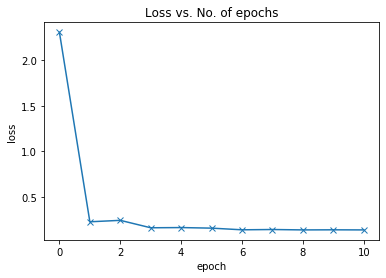

In [91]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

In [92]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1262, val_acc: 0.9649
Epoch [1], val_loss: 0.1273, val_acc: 0.9642
Epoch [2], val_loss: 0.1271, val_acc: 0.9655
Epoch [3], val_loss: 0.1266, val_acc: 0.9642
Epoch [4], val_loss: 0.1282, val_acc: 0.9655


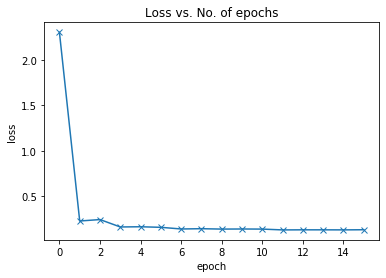

In [93]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

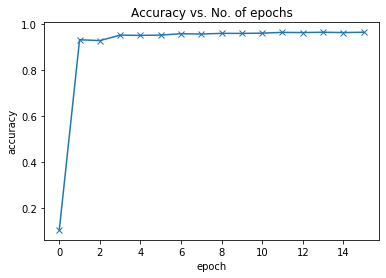

In [94]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [95]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=ToTensor())

In [96]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 7


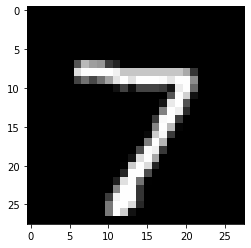

In [97]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 9


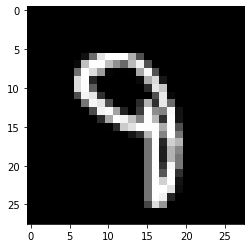

In [98]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 7 , Predicted: 7
Label: 2 , Predicted: 2
Label: 1 , Predicted: 1
Label: 0 , Predicted: 0
Label: 4 , Predicted: 4


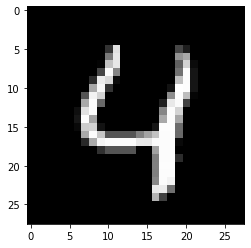

In [100]:
for i in range(5):
    img, label = test_dataset[i]
    plt.imshow(img[0], cmap='gray')
    print('Label:', label, ', Predicted:', predict_image(img, model))

In [101]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.09501289576292038, 'val_acc': 0.972949206829071}